In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from collections import Counter
from textwrap import wrap
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import gget
import tabulate
from sklearn.neighbors import BallTree
from scipy.stats import gmean
from collections import Counter
import sys

"""WARNING: there are no warnings!!!"""
import warnings
warnings.filterwarnings("ignore")


# locals
sys.path.append('../')
import utils as ut

In [2]:
fPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/LR/LewisLabUSCS/Mouse/Mouse-2020-Baccin-LR-pairs.xlsx"

lr = pd.read_excel(fPath, engine="openpyxl")
print(lr.shape)

lr['ligand'] = lr['Ligand.Mouse'].str.upper()
lr['receptor'] = lr['Receptor.Mouse'].str.upper()
lr.head()

(2000, 8)


,Pair.Name,Ligand.Mouse,Receptor.Mouse,Source,ManualAnnotation,Ligand.CC,Ligand.GO,Reference (PMID / KEGG),ligand,receptor
0,A2m-Lrp1,A2m,Lrp1,Ramilowski,Correct,Secreted,Other,"1702392,10652313, 12194978",A2M,LRP1
1,Adgre5-Cd55,Adgre5,Cd55,Baccin,Correct,Membrane,Other,23447688,ADGRE5,CD55
2,Adipoq-Adipor1,Adipoq,Adipor1,Ramilowski,Correct,Secreted,Other,12802337,ADIPOQ,ADIPOR1
3,Adipoq-Adipor2,Adipoq,Adipor2,Ramilowski,Correct,Secreted,Other,"12802337, 12802330",ADIPOQ,ADIPOR2
4,Adm-Calcrl&Ramp2,Adm,Calcrl&Ramp2,Baccin,Correct,Secreted,Other,10342881,ADM,CALCRL&RAMP2


In [3]:
cardOutDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDOuputs/"

dfList = []

for f in os.listdir(cardOutDir):
    if 'global' in f:
        fullPath = f"{cardOutDir}{f}"
        key = f.split("_")[0]
        df = pd.read_csv(fullPath)
        df = df.rename(columns={'Unnamed: 0' : 'spotId'})
        df['key'] = key
        print(f"{key=} {df.shape}")
        dfList.append(df)

df = pd.concat(dfList, ignore_index=True)
print(f"{df.shape=}")
print(df['key'].value_counts())
print()
df.head()

key='ND' (2034, 13)
key='HFD8' (3391, 13)
key='HFD14' (1993, 13)
df.shape=(7418, 13)
key
HFD8     3391
ND       2034
HFD14    1993
Name: count, dtype: int64



,spotId,B cells,Mac1,Mac3,Monocytes,T cells,NK cells,Stromal cells,Dendritic cells,Mac4,Mac2,Mac5,key
0,AAACAAGTATCTCCCA.1_ND,0.018691,0.009410,0.010737,0.070782,0.040298,0.077389,0.645332,0.015281,0.045516,0.039354,0.027211,ND
1,AAACAGCTTTCAGAAG.1_ND,0.008378,0.005700,0.038038,0.089932,0.048618,0.103983,0.575021,0.046758,0.020027,0.035451,0.028094,ND
2,AAACAGGGTCTATATT.1_ND,0.024325,0.010761,0.024323,0.117606,0.072993,0.121093,0.478383,0.026608,0.042051,0.048258,0.033598,ND
3,AAACATTTCCCGGATT.1_ND,0.023002,0.014704,0.044181,0.087019,0.053537,0.083922,0.465958,0.053223,0.087758,0.037452,0.049242,ND
4,AAACCCGAACGAAATC.1_ND,0.021954,0.003784,0.001240,0.038020,0.026386,0.061364,0.775170,0.003725,0.023106,0.025914,0.019336,ND


In [4]:
sptDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

spt = {}

for f in os.listdir(sptDir):
    if "spt" in f and "global" in f:
        print(f)
        fullPath = f"{sptDir}{f}"
        key = f.split("_")[0]
        sdf = pd.read_csv(fullPath)
        sdf = sdf.rename(columns={'Unnamed: 0' : 'gene'})
        sdf = sdf.set_index('gene')
        sdf = sdf.T
        sdf.index = sdf.index.str.replace("-", ".")
        print(f"{key=} {sdf.shape=}")
        spt[key] = sdf
    
print('done')

HFD8_global_spt.csv
key='HFD8' sdf.shape=(3394, 31053)
ND_global_spt.csv
key='ND' sdf.shape=(2036, 31053)
HFD14_global_spt.csv
key='HFD14' sdf.shape=(1994, 31053)
done


In [5]:
coordDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

dfList = []

for f in os.listdir(coordDir):
    if "coord" in f and "global" in f:
        fullPath = f"{coordDir}{f}"
        key = f.split("_")[0]
        cdf = pd.read_csv(fullPath)
        cdf = cdf.rename(columns={'Unnamed: 0' : 'spotId'})
        cdf['key'] = key
        dfList.append(cdf)

cdf = pd.concat(dfList, ignore_index=True)
print(f"{cdf.shape=}")
print(cdf['key'].value_counts())
print()
cdf.head()

cdf.shape=(7424, 4)
key
HFD8     3394
ND       2036
HFD14    1994
Name: count, dtype: int64



,spotId,x,y,key
0,AAACAAGTATCTCCCA.1_HFD8,1244.795278,1189.669724,HFD8
1,AAACACCAATAACTGC.1_HFD8,405.548324,1349.579809,HFD8
2,AAACAGCTTTCAGAAG.1_HFD8,303.880251,1068.178931,HFD8
3,AAACAGGGTCTATATT.1_HFD8,344.496391,1138.478061,HFD8
4,AAACAGTGTTCCTGGG.1_HFD8,648.734268,1595.524585,HFD8


In [6]:
"""Merge CARD predictions with spatial coordinates"""
df = pd.merge(cdf, df,
              how='left', 
              left_on=['spotId', 'key'],
              right_on=['spotId', 'key'])

df = df.fillna(0)
df = df.drop_duplicates() # very important!
print(df['key'].value_counts())
df.head()

key
HFD8     3394
ND       2036
HFD14    1994
Name: count, dtype: int64


,spotId,x,y,key,B cells,Mac1,Mac3,Monocytes,T cells,NK cells,Stromal cells,Dendritic cells,Mac4,Mac2,Mac5
0,AAACAAGTATCTCCCA.1_HFD8,1244.795278,1189.669724,HFD8,0.077635,0.022735,0.104811,0.111453,0.125867,0.195064,0.059765,0.111978,0.082445,0.066571,0.041676
1,AAACACCAATAACTGC.1_HFD8,405.548324,1349.579809,HFD8,0.076987,0.041831,0.047343,0.139484,0.082711,0.093085,0.148247,0.071763,0.058744,0.142045,0.097760
2,AAACAGCTTTCAGAAG.1_HFD8,303.880251,1068.178931,HFD8,0.079216,0.043327,0.075868,0.086821,0.086695,0.097747,0.186142,0.090520,0.069670,0.094246,0.089748
3,AAACAGGGTCTATATT.1_HFD8,344.496391,1138.478061,HFD8,0.037682,0.029618,0.093281,0.109521,0.052151,0.061401,0.201332,0.094533,0.143671,0.088173,0.088637
4,AAACAGTGTTCCTGGG.1_HFD8,648.734268,1595.524585,HFD8,0.092691,0.001555,0.002745,0.075636,0.054631,0.052849,0.112912,0.008552,0.258918,0.056771,0.282740


In [7]:
# break

ND mean: 110.2 median: 91.0
HFD8 mean: 158.8 median: 105.0
HFD14 mean: 232.7 median: 173.0
165.3081896551724


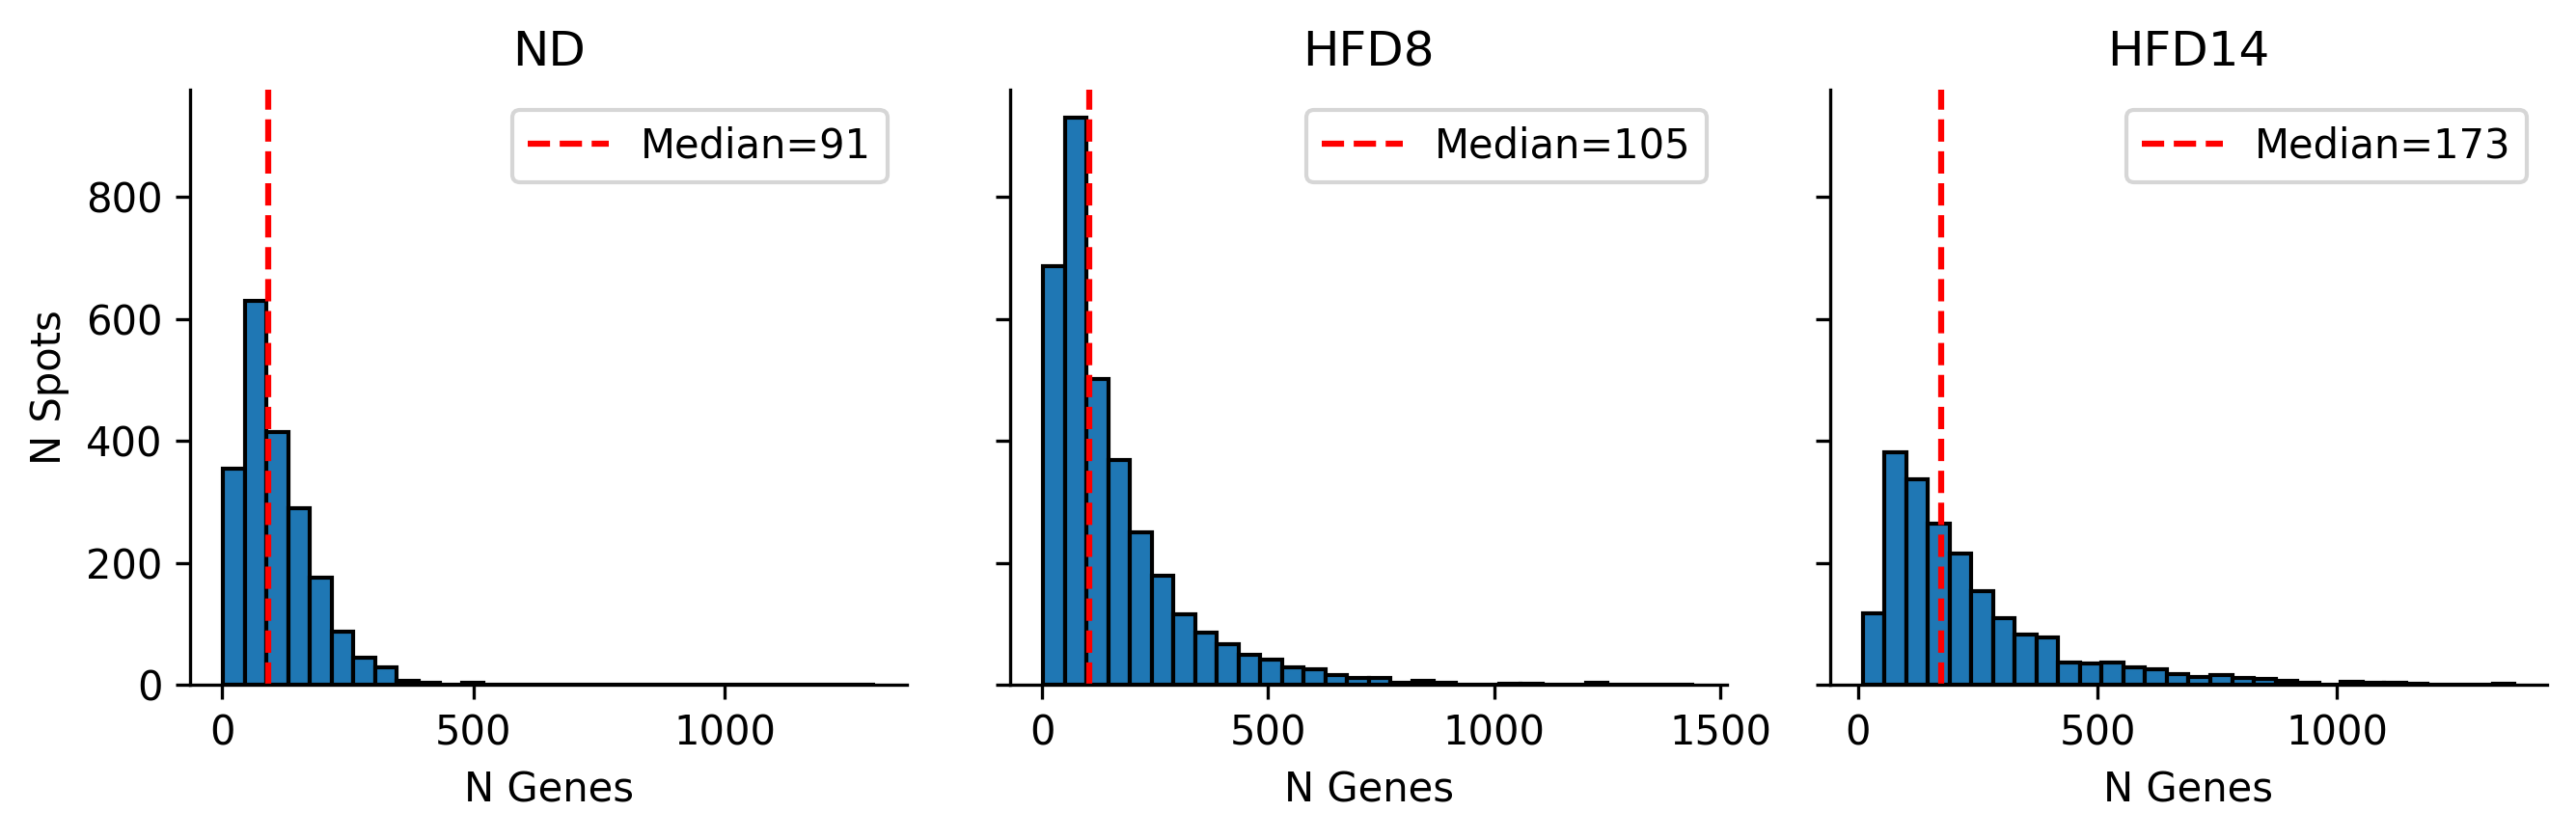

In [8]:
keys = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 9, 3

allMean = []

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()

res = []

for i, key in enumerate(keys):
    sdf = spt[key]
    
    bdf = sdf.astype(bool)
    rowSums = bdf.sum(axis=1)

    tmp = pd.DataFrame(rowSums)
    tmp['key'] = key
    res.append(tmp)
    
    allMean += rowSums.to_list()

    
    
    print(f"{key} mean: {rowSums.mean():.1f} median: {rowSums.median():.1f}")
    
    axs[i].hist(rowSums, 
                edgecolor='k', 
                bins=30)

    axs[i].set_xlabel("N Genes")
    if i == 0:
        axs[i].set_ylabel("N Spots")
    else:
        axs[i].set_ylabel("")
    axs[i].set_title(key)
    
    axs[i].axvline(x=rowSums.median(), 
                   c='r', 
                   ls="--", 
                   label=f"Median={int(rowSums.median())}")
    
    axs[i].legend(loc='upper right')
    
    # break
    
plt.tight_layout()
sns.despine()
res = pd.concat(res)

print(np.mean(allMean))

In [9]:
res.columns = ['count', 'key']
outdir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/SUPP/"
fname = "spatialTransReadCounts.csv"
res.to_csv(f"{outdir}{fname}")
res.head()

,count,key
AAACAAGTATCTCCCA.1_ND,109,ND
AAACAGCTTTCAGAAG.1_ND,69,ND
AAACAGGGTCTATATT.1_ND,105,ND
AAACATTTCCCGGATT.1_ND,135,ND
AAACCCGAACGAAATC.1_ND,91,ND


In [10]:
# break 

In [11]:
keys = ['ND', 'HFD8', 'HFD14']

lrData = {}

for key in keys:
    sdf = spt[key]
    newCols = {}
    
    for idx, row in lr.iterrows():
        l = row['ligand']
        r = row['receptor']
        
        if l in sdf.columns and r in sdf.columns:
            gMean = gmean(sdf[[l, r]], axis=1)
            lrName = row['Pair.Name']
            newCols[lrName] = gMean
    
    lrdf = pd.DataFrame(newCols)
    lrdf.index = sdf.index
    
    # remove zero-sum columns 
    lrdf = lrdf.loc[:, (lrdf.sum(axis=0) != 0)]
    print(sdf.shape, lrdf.shape)
    
    lrData[key] = lrdf


print('done')

(2036, 31053) (2036, 124)
(3394, 31053) (3394, 253)
(1994, 31053) (1994, 270)
done


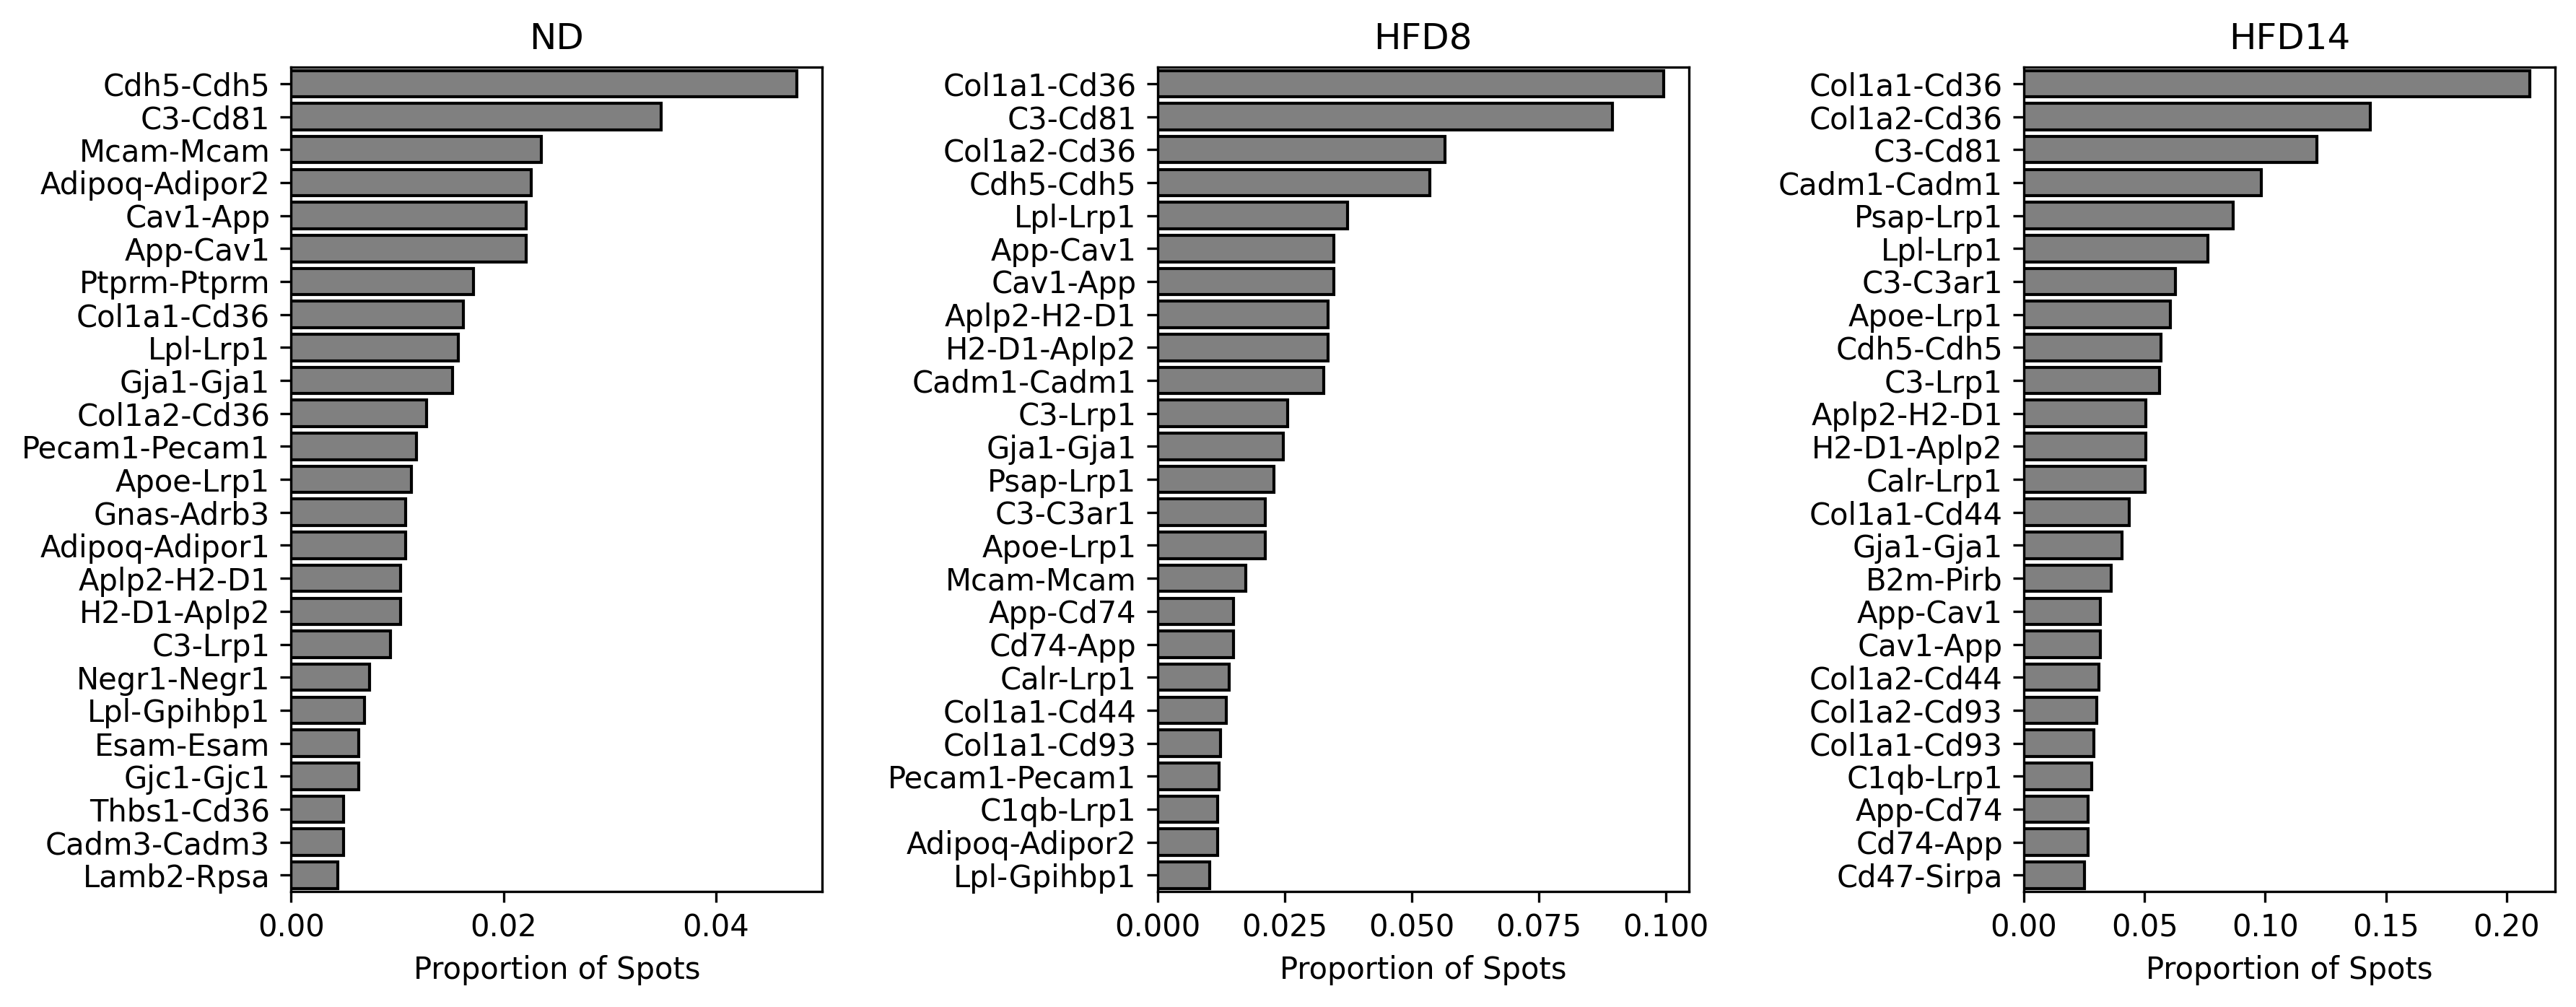

In [12]:
n = 25

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 12, 4.75

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

for i, key in enumerate(keys):
    ldf = lrData[key]
    ldfBool = ldf.astype(bool) 
    colSumns = ldfBool.sum(axis=0)
    prop = colSumns / len(ldfBool)
    prop = pd.DataFrame(prop)
    prop = prop.reset_index(drop=False)
    prop.columns = ['LR', 'Proportion']
    prop = prop.sort_values(by='Proportion', ascending=False)
    # print(f"==== {key} ====")
    # print(prop.head(n))
    
    sns.barplot(data=prop.head(n),
                y='LR', 
                x='Proportion', 
                color='grey',
                edgecolor='k',
                ax=axs[i])
    
    
    axs[i].set_ylabel("")
    axs[i].set_xlabel("Proportion of Spots")
    axs[i].set_title(key)
    
plt.tight_layout()


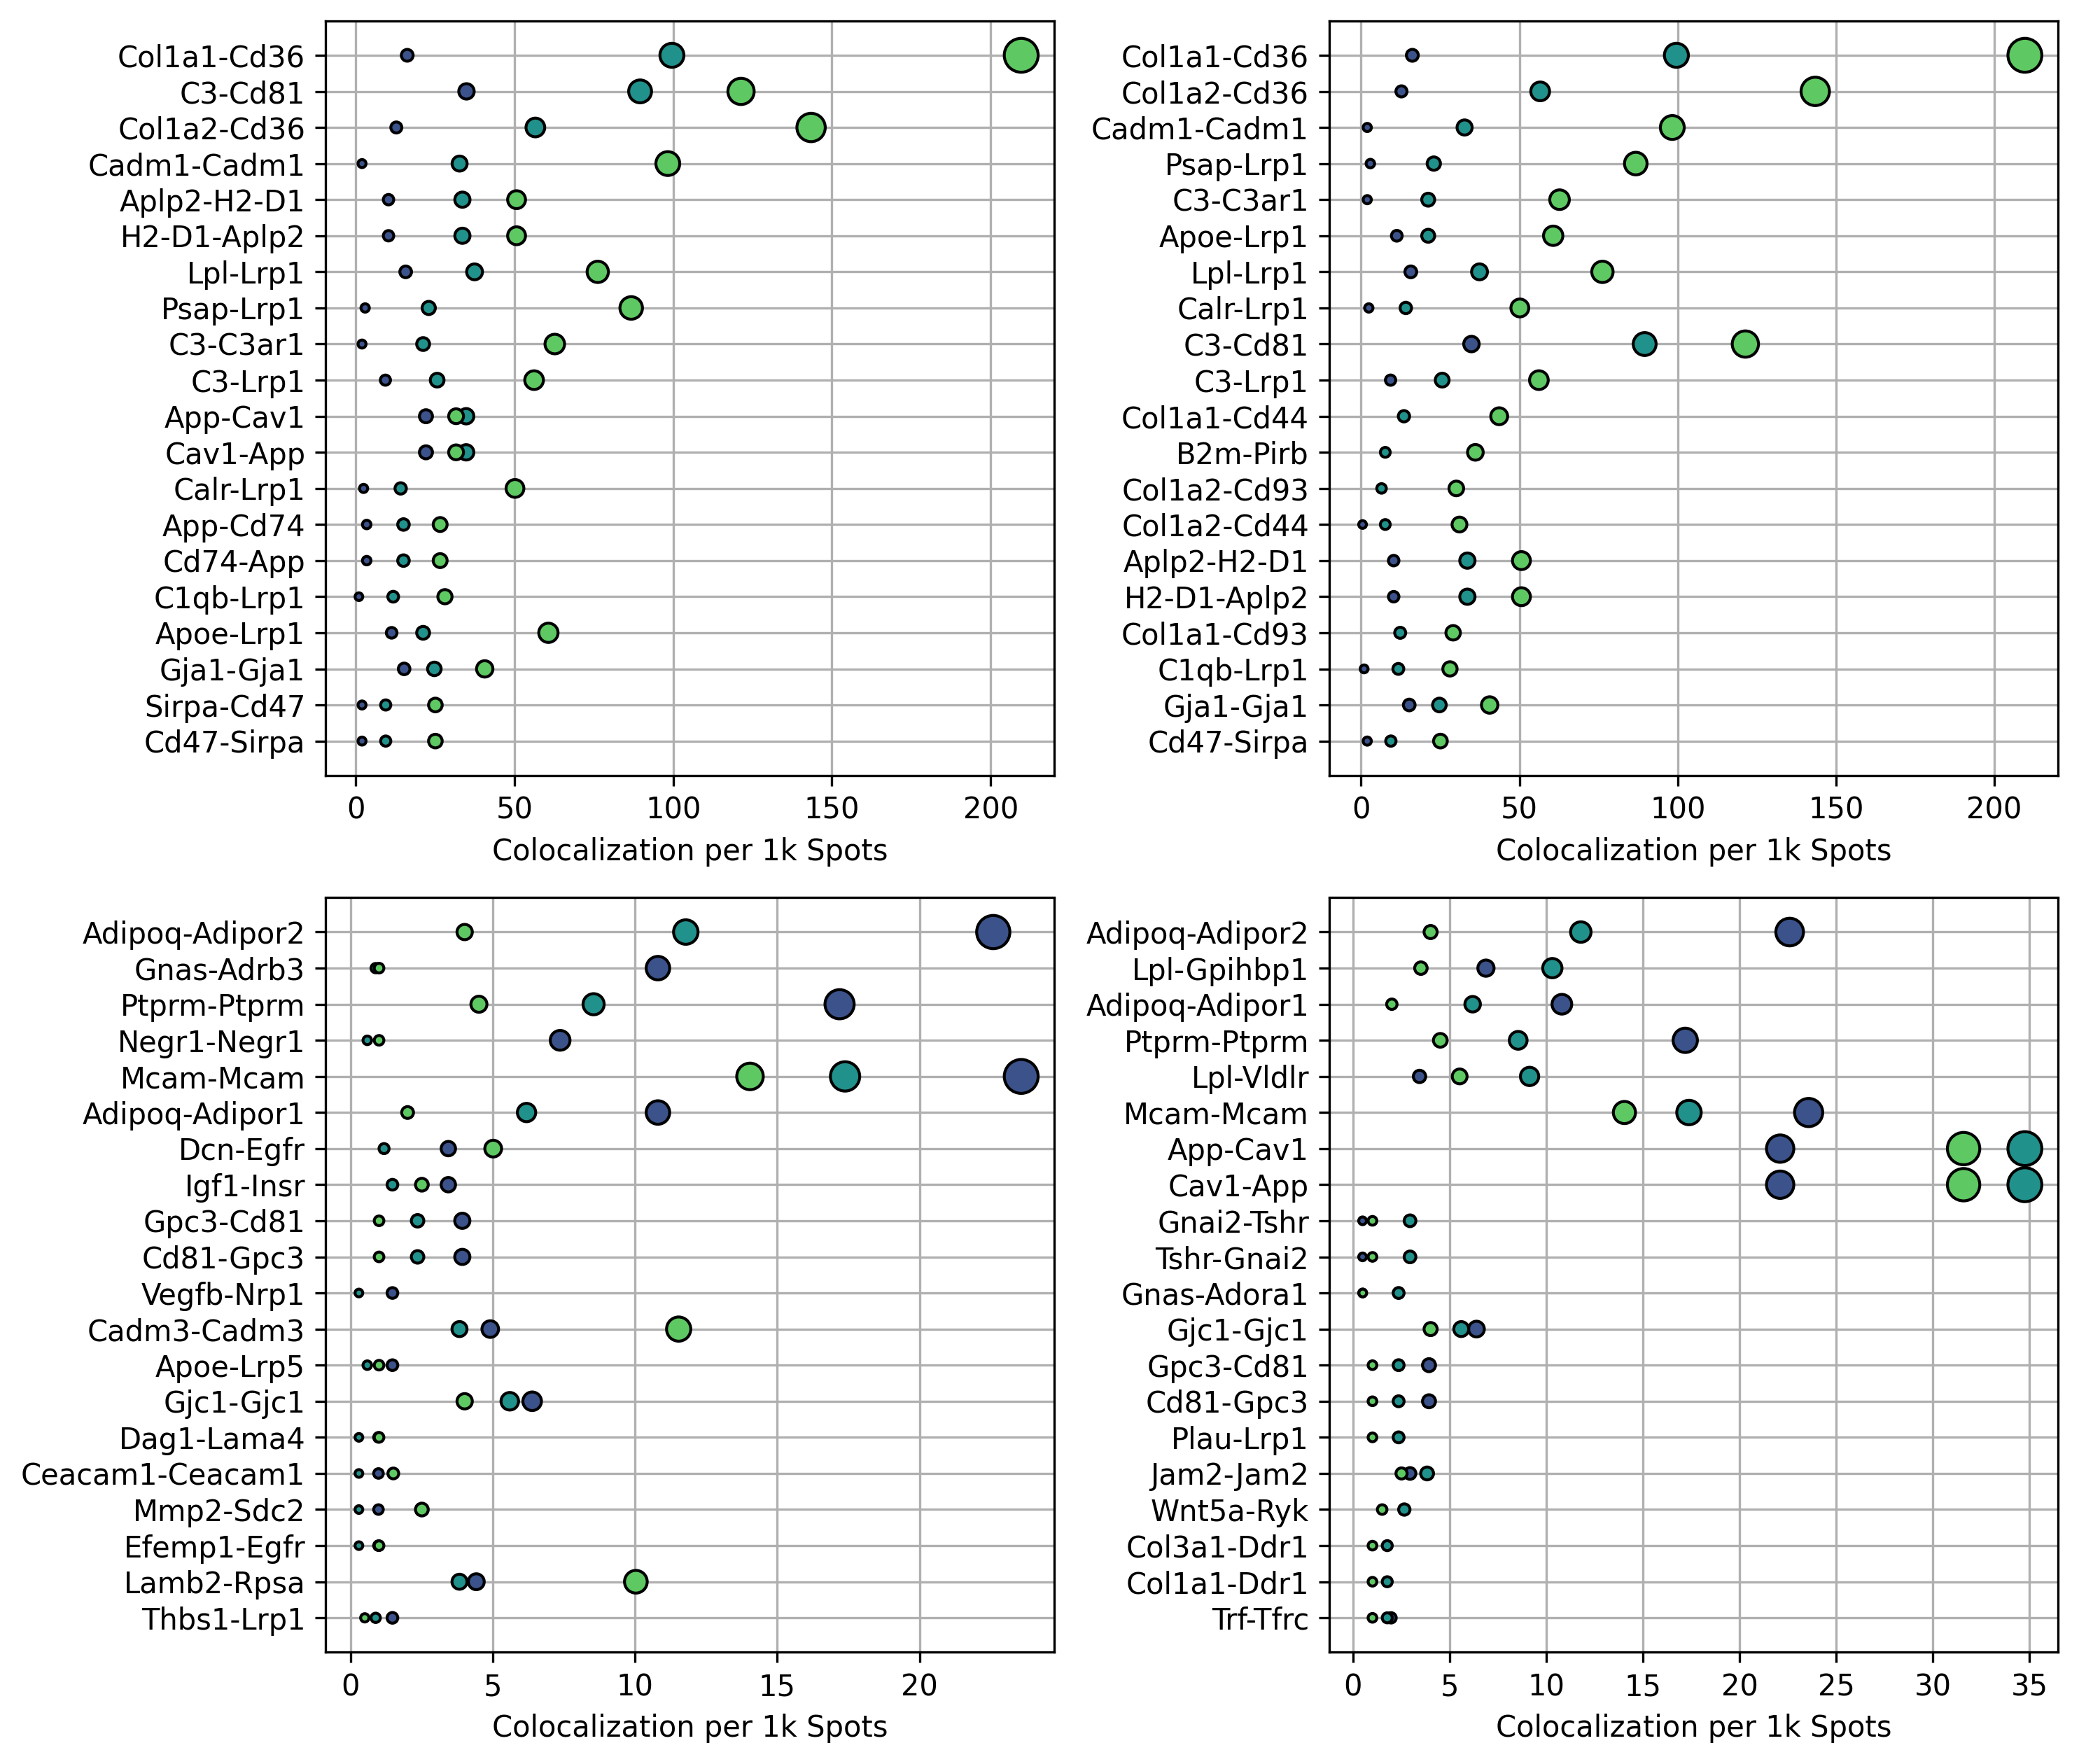

In [13]:
res = []

top = 20

for i, key in enumerate(keys):
    sdf = spt[key]
    ldf = lrData[key]
    ldfBool = ldf.astype(bool) 
    colSums = ldfBool.sum(axis=0)
    colSums = colSums * 1000 / len(sdf) # colocalization per 1000 spots
    
    res.append(colSums)
    
res = pd.concat(res, axis=1)
res.columns = keys
res = res.reset_index(drop=False)

# res.head()


res['HFD8vND'] = res['HFD8'] - res['ND']
res['HFD14vHFD8'] = res['HFD14'] - res['HFD8']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 10, 8.5
fig, axs = plt.subplots(2, 2)


for i, up in enumerate([False, True]):
    for j, diff in enumerate(['HFD8vND', 'HFD14vHFD8']):    
        pdf = res.sort_values(by=diff, ascending=up)
        pdf = pdf.head(top)
        pdf = pd.melt(pdf, id_vars='index', value_vars=keys)
        
        sns.scatterplot(data=pdf, 
                          x='value',
                          y='index',
                          ax=axs[i, j],
                          hue='variable',
                          size='value',
                          sizes=(7, 135),
                          legend=False,
                          linewidth=1,
                          ec='k',
                          palette='viridis',
                          zorder=2)
        
        axs[i, j].grid(True, zorder=1)
        axs[i, j].set_ylabel("")
        axs[i, j].set_xlabel("Colocalization per 1k Spots")
        
#         print(pdf.head())
        
plt.tight_layout()

In [14]:
outdir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/FIG7/"
fname = "lrSummary.csv"
res.to_csv(f"{outdir}{fname}", index=False)
res.head()

,index,ND,HFD8,HFD14,HFD8vND,HFD14vHFD8
0,Adipoq-Adipor1,10.805501,6.187390,2.006018,-4.618111,-4.181371
1,Adipoq-Adipor2,22.593320,11.785504,4.012036,-10.807816,-7.773468
2,Apoe-Ldlr,0.491159,4.124926,6.519559,3.633767,2.394632
3,Apoe-Lrp1,11.296660,21.213907,60.682046,9.917247,39.468139
4,Apoe-Lrp5,1.473477,0.589275,1.003009,-0.884202,0.413734


In [15]:
# break

Wed Jun 21 09:56:50 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Wed Jun 21 09:56:51 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Wed Jun 21 09:56:52 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Wed Jun 21 09:56:52 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriat

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database,logp,nGene,up,diff
0,1,cellular response to peptide (GO:1901653),3.986447e-09,112.703620,2179.729204,"[APP, GJA1, LRP1, CAV1, CD36]",0.000003,GO_Biological_Process_2021,8.399414,5,False,HFD8vND
1,2,receptor-mediated endocytosis (GO:0006898),8.162936e-09,54.309307,1011.438162,"[LRP1, CD81, CAV1, APOE, CD36, CALR]",0.000004,GO_Biological_Process_2021,8.088154,6,False,HFD8vND
2,3,positive regulation of transport (GO:0051050),4.322178e-08,68.030096,1153.580973,"[LRP1, SIRPA, APOE, CD47, CALR]",0.000010,GO_Biological_Process_2021,7.364297,5,False,HFD8vND
3,4,cellular response to amyloid-beta (GO:1904646),5.619232e-08,142.989247,2387.131949,"[APP, GJA1, LRP1, CD36]",0.000010,GO_Biological_Process_2021,7.250323,4,False,HFD8vND
4,5,positive regulation of multicellular organismal process (GO:0051240),5.837192e-08,27.116371,451.661955,"[COL1A1, GJA1, LRP1, CADM1, CAV1, APOE, CD36]",0.000010,GO_Biological_Process_2021,7.233796,7,False,HFD8vND


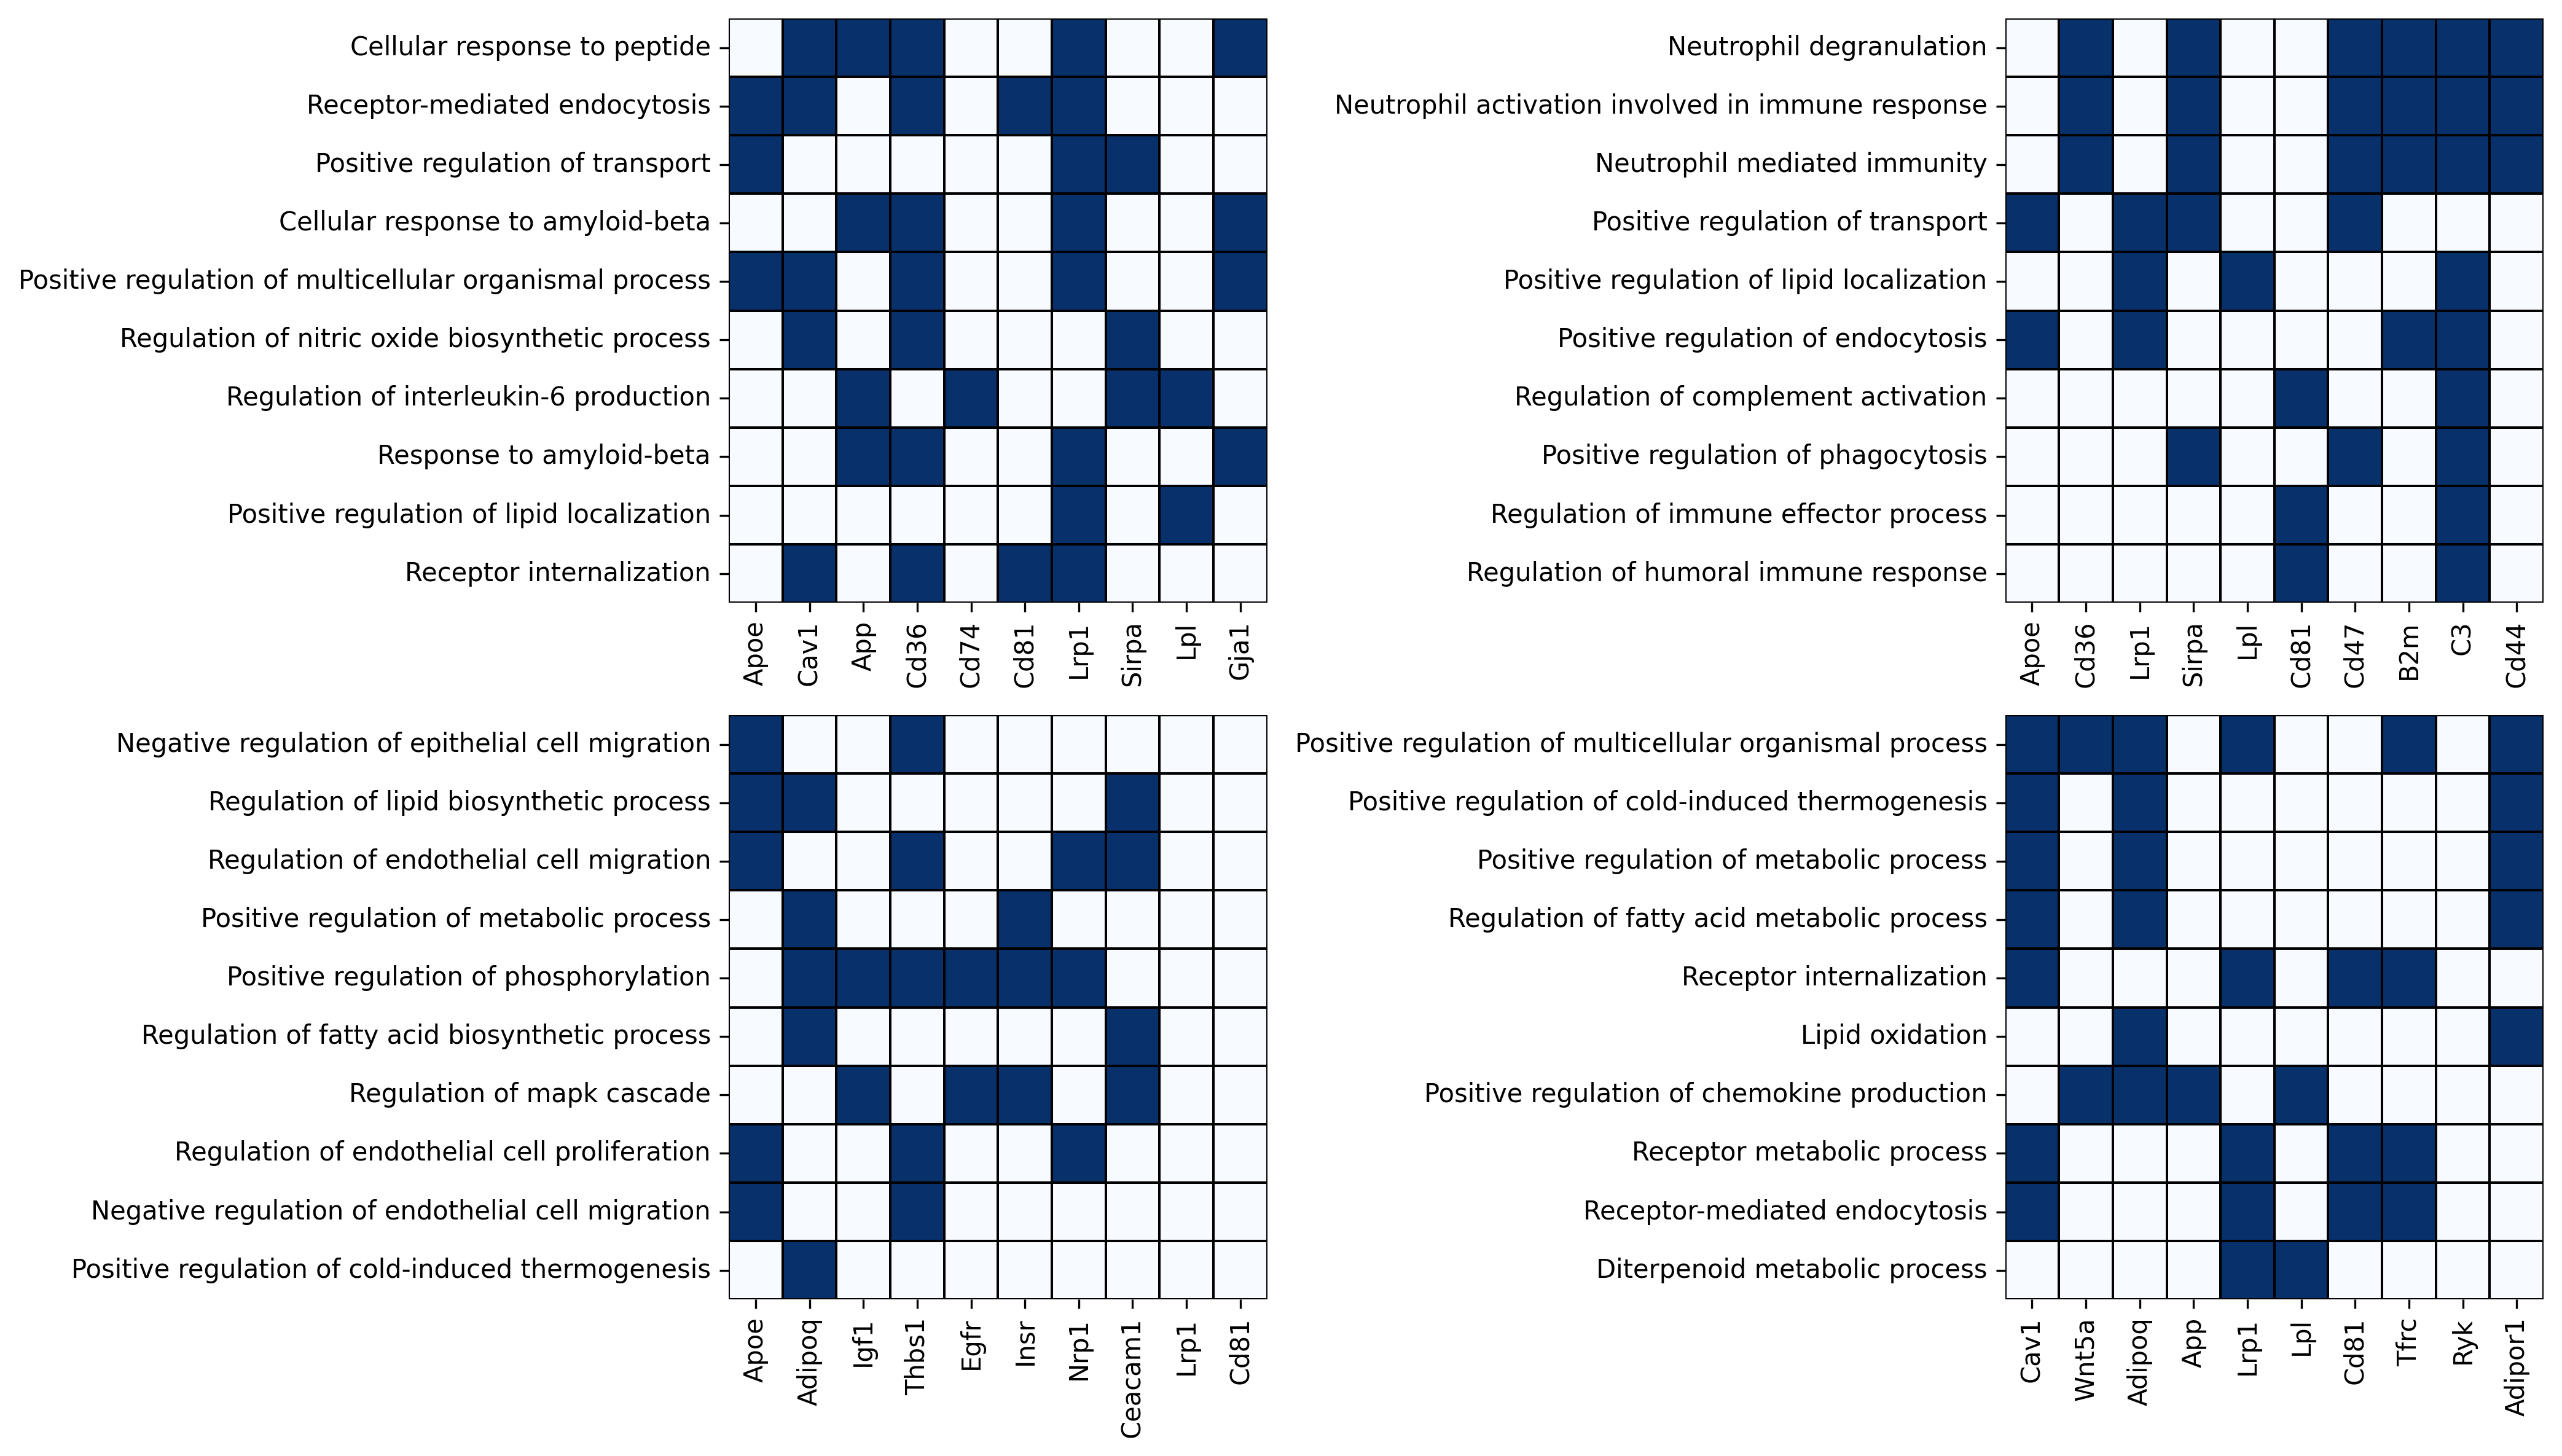

In [16]:
pd.options.display.max_colwidth = 100

# db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'

top = 20
alpha = 0.05
npathways = 10
ngenes = 10

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 14, 8
fig, axs = plt.subplots(2, 2)

edf = []

for i, up in enumerate([False, True]):
    for j, diff in enumerate(['HFD8vND', 'HFD14vHFD8']):    
        pdf = res.sort_values(by=diff, ascending=up)
        pdf = pdf.head(top)
        
        genes = pdf['index'].apply(lambda x: np.array(x.split("-")))
        genes = list(set([g for row in genes for g in row]))
        
        ef = gget.enrichr(genes, database=db)
        ef['logp'] = ef['p_val'].apply(lambda x: -np.log10(x))
        ef = ef[ef['adj_p_val'] < alpha]
        ef['nGene'] = ef['overlapping_genes'].apply(lambda x: len(x))
        
        
        geneCount = Counter([g for row in ef['overlapping_genes'] for g in row])
        displayGenes = [x[0] for x in geneCount.most_common(ngenes)]
        
        ef2 = ef.overlapping_genes.str.join('|').str.get_dummies()
        ef2.index = ef['path_name'].apply(lambda x: x.split("(")[0].capitalize())
        ef2.index = [ '\n'.join(wrap(l, 60)) for l in ef2.index ]
        ef2 = ef2[displayGenes]
        ef2.columns = [str(x).lower().capitalize() for x in ef2.columns]

        ef['up'] = up
        ef['diff'] = diff
        edf.append(ef)
        
        sns.heatmap(data=ef2.head(npathways),
                    ax=axs[i, j],
                    cbar=False,
                    linewidth=0.5,
                    linecolor='k',
                    cmap=plt.cm.get_cmap('Blues', lut=3))
        
        axs[i, j].set_ylabel("")
        axs[i, j].set_xlabel("")
        axs[i, j].tick_params(axis='x', labelrotation=90)
        
        # print(ef['path_name'])
#         print()
    # break


plt.tight_layout()

edf = pd.concat(edf)
edf.head()


In [17]:
# outdir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/SUPP/"
# fname = "lr_GO_enrichments.csv"
# edf.to_csv(f"{outdir}{fname}", index=False)
# # edf.head()

In [18]:
# break

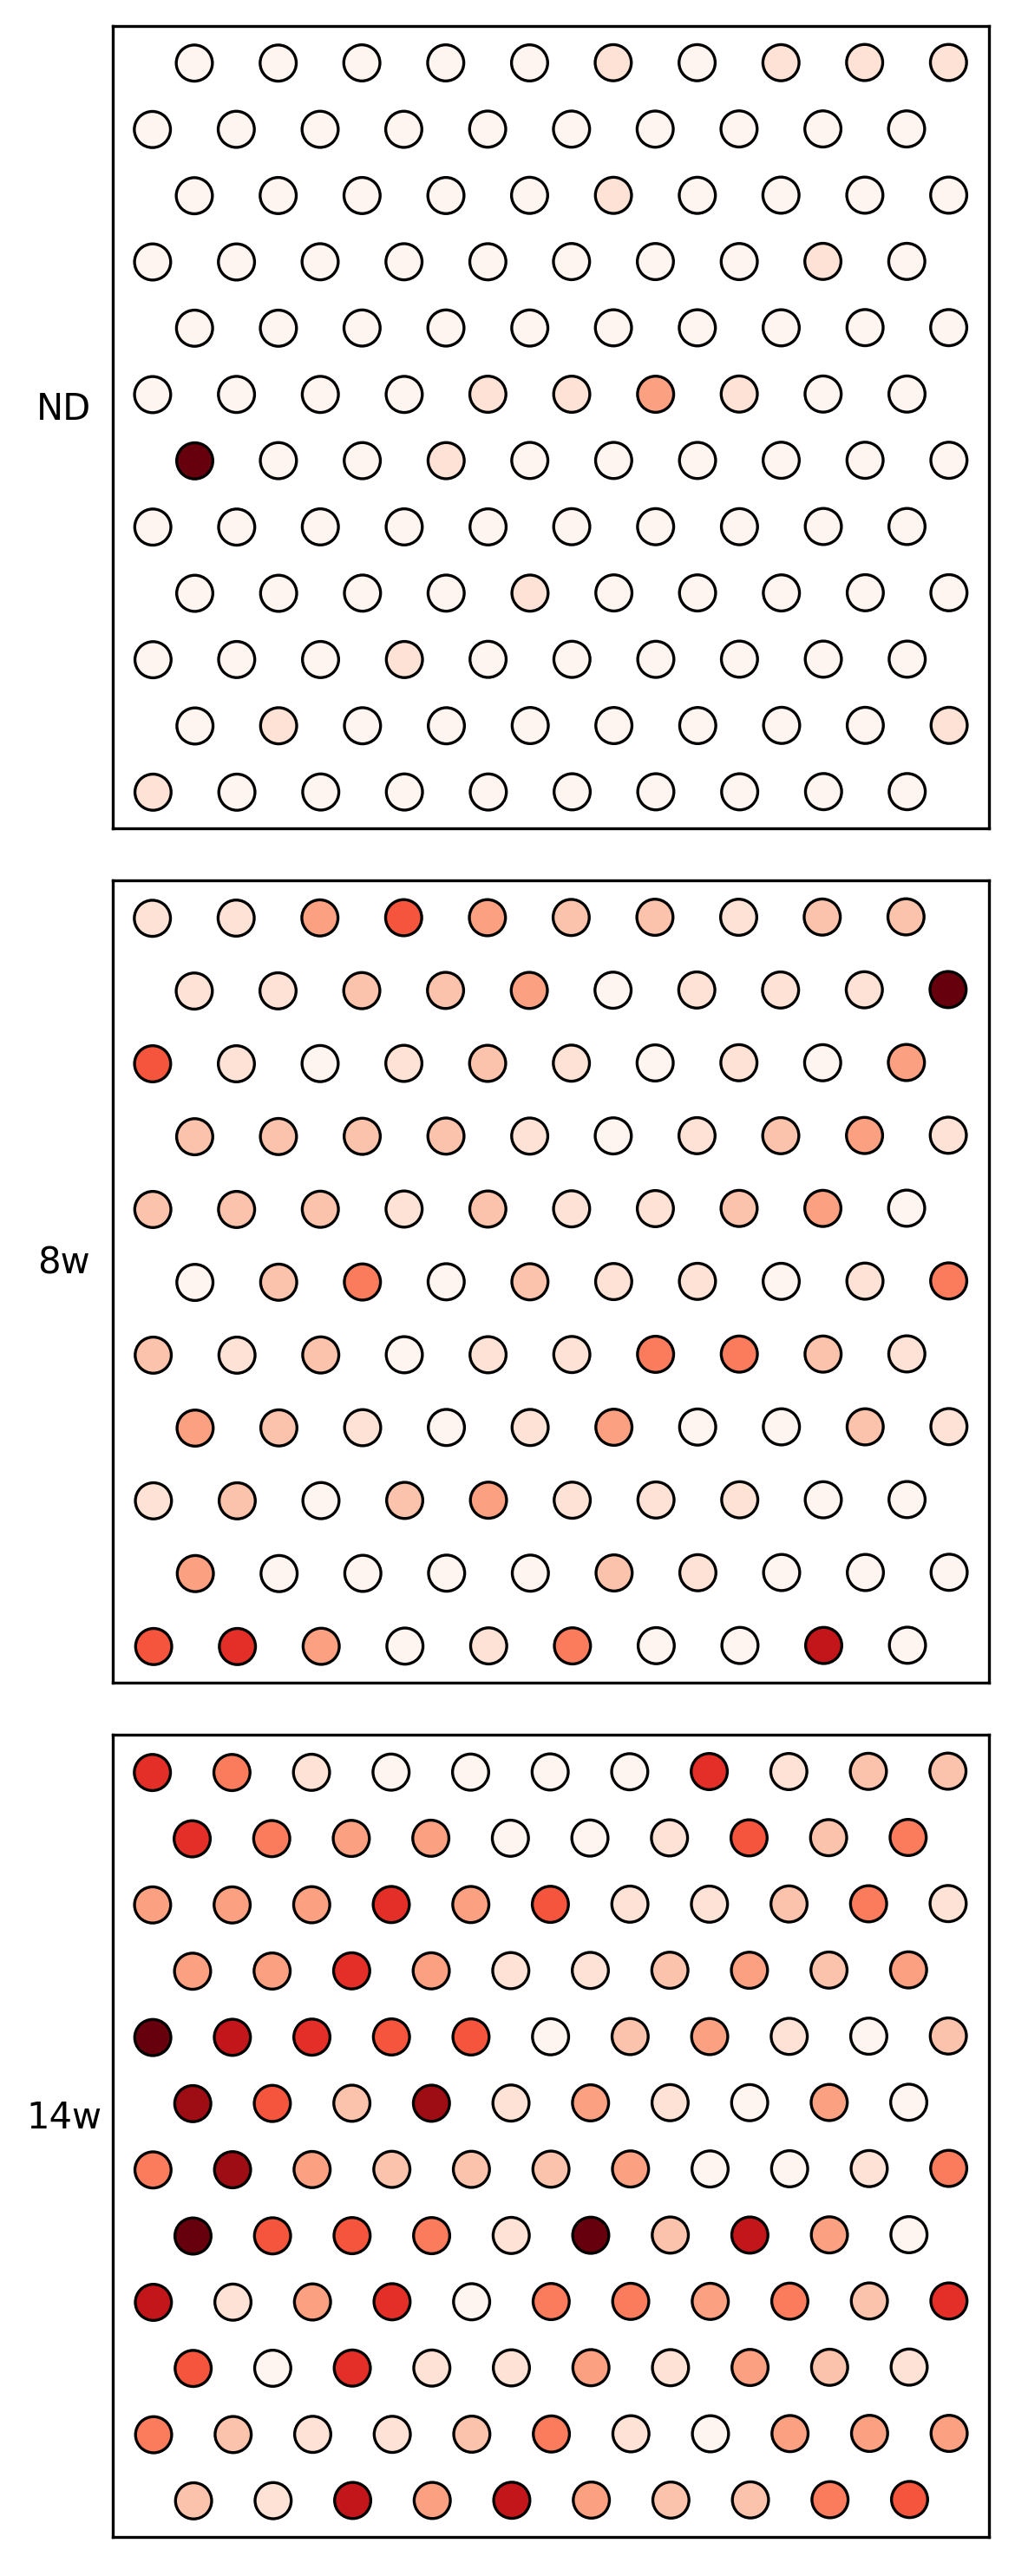

In [19]:


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 10
fig, axs = plt.subplots(3, 1)
axs = axs.ravel()


boxes = {
    'ND' : [1000, 1200, 1000, 1200],
    'HFD8' :  [1000, 1200, 1000, 1200],
    'HFD14' :  [600, 800, 1000, 1200],
}

pltLabels = ['ND', '8w', '14w']

for i, key in enumerate(keys):
    # sdf = spt[key]
    ldf = lrData[key]
    kdf = df[df['key'] == key]
    
    pdf = pd.merge(kdf, ldf, 
                   how='left',
                   left_on='spotId',
                   right_index=True)
    
    bbox = boxes[key]
    
    pdf = pdf[(pdf['x'] > bbox[0]) & (pdf['x'] < bbox[1])]
    pdf = pdf[(pdf['y'] > bbox[2]) & (pdf['y'] < bbox[3])]
    
    
    sns.scatterplot(data=pdf,
                    x='x',
                    y='y',
                    hue='Mac5',
                    s=100,
                    ec='k',
                    legend=False,
                    # alpha=1,
                    ax=axs[i],
                    palette=plt.cm.get_cmap('Reds', lut=10))
    
    axs[i].invert_yaxis()
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_ylabel(pltLabels[i], rotation=0, labelpad=10)
    axs[i].set_xlabel("")
    
plt.tight_layout()
#     
#     print(pdf.shape, ldf.shape, kdf.shape)
    
    
#     break

In [20]:
ldf.head()

,Adipoq-Adipor1,Adipoq-Adipor2,Alcam-L1cam,Angpt1-Itgb1,Apln-Aplnr,Apoe-Ldlr,Apoe-Lrp1,Apoe-Lrp5,Apoe-Scarb1,Apoe-Vldlr,...,Pf4-Sdc2,Pf4-Thbd,Psap-Celsr1,Rarres2-Cmklr1,Rspo1-Lgr4,Rtn4-Rtn4r,Rtn4r-Rtn4,Tshr-Gnai2,Wnt5a-Fzd8,Fgf1-Cd44
AAACATTTCCCGGATT.1_HFD14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGGGTAGGTACC.1_HFD14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTTCGTCCAGG.1_HFD14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTAAGCAGCCGG.1_HFD14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTCATGAAGTTG.1_HFD14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# break

In [22]:
def printGSR(ef, top=None, columns=['path_name', 'overlapping_genes']):
    """A function to print pathway results """
    n = top
    if top is None:
        n = len(ef)

    ef['overlapping_genes'] = ef['overlapping_genes'].apply(lambda x: ", ".join(x))
    printDf = ef[columns].head(n)
    print(tabulate.tabulate(printDf, 
                            headers=columns, 
                            showindex=False,
                            tablefmt='orgtbl'))

# 'plain', 'simple', 'grid', 'pipe', 'orgtbl', 'rst', 'mediawiki',
# 'latex', 'latex_raw', 'latex_booktabs', 'latex_longtable' and tsv.
# Variable `tabulate_formats`contains the list of currently supported formats.

In [23]:
alpha = 0.05
top = 20
# db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'


def flatten(l):
    return [item for sublist in l for item in sublist]

# look at the top ligand-receptors
for i, key in enumerate(keys):
    ldf = lrData[key]
    ldfBool = ldf.astype(bool) 
    colSumns = ldfBool.sum(axis=0)
    prop = colSumns / len(ldfBool)
    prop = pd.DataFrame(prop)
    prop = prop.reset_index(drop=False)
    prop.columns = ['LR', 'Proportion']
    prop = prop.sort_values(by='Proportion', ascending=False)
    
    pairs = prop['LR'].head(top).to_list()
    genes = flatten([x.split("-") for x in pairs])
    ef = gget.enrichr(genes, database=db)
    ef = ef[ef['p_val'] <= alpha]
    pd.set_option('display.max_colwidth', 200)
    
    print(f"==== {key} ====")
    printGSR(ef, top=10)
    print()
    print(pairs)
    print()
    
    # break

Wed Jun 21 09:56:55 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Wed Jun 21 09:56:55 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


==== ND ====
| path_name                                                            | overlapping_genes                                                           |
|----------------------------------------------------------------------+-----------------------------------------------------------------------------|
| positive regulation of multicellular organismal process (GO:0051240) | COL1A1, GJA1, LRP1, ADRB3, CAV1, ADIPOQ, GNAS, APOE, CD36, ADIPOR1, ADIPOR2 |
| positive regulation of cold-induced thermogenesis (GO:0120162)       | GJA1, ADRB3, CAV1, ADIPOQ, GNAS, CD36, ADIPOR1, ADIPOR2                     |
| positive regulation of metabolic process (GO:0009893)                | GJA1, ADRB3, CAV1, ADIPOQ, GNAS, CD36, ADIPOR1, ADIPOR2                     |
| regulation of lipid biosynthetic process (GO:0046890)                | C3, ADIPOQ, APOE, ADIPOR1, ADIPOR2                                          |
| regulation of fatty acid metabolic process (GO:0019217)              | CAV1, AD

Wed Jun 21 09:56:55 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


==== HFD8 ====
| path_name                                                                   | overlapping_genes                           |
|-----------------------------------------------------------------------------+---------------------------------------------|
| cellular response to peptide (GO:1901653)                                   | APP, GJA1, LRP1, CAV1, CD36                 |
| receptor-mediated endocytosis (GO:0006898)                                  | LRP1, CD81, CAV1, APOE, CD36, CALR          |
| cellular response to amyloid-beta (GO:1904646)                              | APP, GJA1, LRP1, CD36                       |
| positive regulation of multicellular organismal process (GO:0051240)        | COL1A1, GJA1, LRP1, CADM1, CAV1, APOE, CD36 |
| response to amyloid-beta (GO:1904645)                                       | APP, GJA1, LRP1, CD36                       |
| positive regulation of lipid localization (GO:1905954)                      | C3, LRP1, LPL          

In [24]:
""" Query LR pairs"""

alpha = 0.01
top = 20
# db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'


queryPairs = ['Col1a1-Cd36', 'Col1a2-Cd36','Cadm1-Cadm1','C3-Cd81', ]

genes = flatten([x.split("-") for x in queryPairs])
ef = gget.enrichr(genes, database=db)

ef = ef[ef['adj_p_val'] <= alpha]
pd.set_option('display.max_colwidth', 200)

print(f"==== {key} ====")
printGSR(ef, top=10)


Wed Jun 21 09:56:56 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


==== HFD14 ====
| path_name                                                                   | overlapping_genes        |
|-----------------------------------------------------------------------------+--------------------------|
| regulation of immune response (GO:0050776)                                  | COL1A1, C3, COL1A2, CD81 |
| skin morphogenesis (GO:0043589)                                             | COL1A1, COL1A2           |
| cellular response to low-density lipoprotein particle stimulus (GO:0071404) | CD81, CD36               |
| receptor internalization (GO:0031623)                                       | CD81, CD36               |
| regulation of complement activation (GO:0030449)                            | C3, CD81                 |
| positive regulation of multicellular organismal process (GO:0051240)        | COL1A1, CADM1, CD36      |
| regulation of immune effector process (GO:0002697)                          | C3, CD81                 |
| supramolecular fibe

In [25]:
queryPairs = [
   'Apoe-Lrp1',
   'Col1a2-Cd36',
]

cTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Monocytes',
    'T cells',
    'NK cells', 
    'Dendritic cells', 
    'Stromal cells', 
    'B cells'
]

layer = 1

for key in keys:
    ldf = lrData[key][queryPairs].reset_index(drop=False)
    ldf = ldf.rename(columns={'index':'spotId'})
    cdf = df[df['key'] == key].reset_index(drop=True)
    
    cdf['cType'] = cdf[cTypes].apply(lambda x: cTypes[np.argsort(x)[-layer]], axis=1)
    
    tdf = pd.merge(cdf, ldf, 
                   how='left', 
                   left_on='spotId',
                   right_on='spotId')
    
    print(f"============= {key} =============")
    for q in queryPairs:
        print(f"==== {q} ====")
        qdf = tdf[tdf[q] > 0]
        print(qdf['cType'].value_counts(normalize=True), '\n')

============= ND =============
==== Apoe-Lrp1 ====
cType
Stromal cells    1.0
Name: proportion, dtype: float64 

==== Col1a2-Cd36 ====
cType
Stromal cells    0.961538
Mac5             0.038462
Name: proportion, dtype: float64 

============= HFD8 =============
==== Apoe-Lrp1 ====
cType
Stromal cells      0.583333
Mac5               0.388889
Mac4               0.013889
Dendritic cells    0.013889
Name: proportion, dtype: float64 

==== Col1a2-Cd36 ====
cType
Stromal cells      0.760417
Mac5               0.208333
Dendritic cells    0.010417
Monocytes          0.005208
Mac2               0.005208
NK cells           0.005208
Mac4               0.005208
Name: proportion, dtype: float64 

============= HFD14 =============
==== Apoe-Lrp1 ====
cType
Mac5             0.669421
Stromal cells    0.314050
Mac2             0.008264
Mac4             0.008264
Name: proportion, dtype: float64 

==== Col1a2-Cd36 ====
cType
Stromal cells      0.479021
Mac5               0.468531
Dendritic cells    0.024

In [26]:
""" neighboorhood around an LR pair """

k = 7

queryPairs = [
    'Apoe-Lrp1',
]


for key in keys:
    ldf = lrData[key][queryPairs].reset_index(drop=False)
    ldf = ldf.rename(columns={'index':'spotId'})
    cdf = df[df['key'] == key].reset_index(drop=True)
    
    X = cdf[['x', 'y']]
    tree = BallTree(X, leaf_size=10, metric='euclidean')
    
    globalProp = pd.DataFrame(cdf[sorted(cTypes)].mean(axis=0)).reset_index()
    globalProp.columns = ['Cell Type', 'GlobalProp']
    
    print(f"============= {key} =============")
    for q in queryPairs:
        print(f"==== {q} ====")
        mask = ldf[q] > 0
        print(f"{mask.sum()} ({mask.sum() / len(mask):.3f}) spots have {q} > 0")
        
        spotIds = ldf[mask]['spotId'].to_list()
        mask = cdf['spotId'].isin(spotIds)
        gf = cdf[mask]
        
        dist, ind = tree.query(X[mask], k=k)
        
        indx = np.unique(np.ravel(ind))
        locs = cdf[cdf.index.isin(indx)]
        
        print(f"{len(locs)} ({len(locs) / len(mask):.3f}) spots are within {k} neighbors")
        locs = pd.DataFrame(locs[sorted(cTypes)].mean(axis=0)).reset_index()
        locs.columns = ['Cell Type', 'QueryProp']
        locs['GlobalProp'] = globalProp['GlobalProp']
        locs['diff'] = locs['QueryProp'] - locs['GlobalProp']
        
        locs = locs.sort_values(by='QueryProp', ascending=False)        
        print(locs)

        print()

============= ND =============
==== Apoe-Lrp1 ====
23 (0.011) spots have Apoe-Lrp1 > 0
158 (0.078) spots are within 7 neighbors
          Cell Type  QueryProp  GlobalProp      diff
9     Stromal cells   0.684431    0.673088  0.011343
8          NK cells   0.066523    0.069110 -0.002587
7         Monocytes   0.053904    0.058082 -0.004178
6              Mac5   0.045708    0.038281  0.007427
5              Mac4   0.033599    0.033297  0.000302
10          T cells   0.032867    0.035273 -0.002406
3              Mac2   0.030304    0.032330 -0.002025
1   Dendritic cells   0.015215    0.017723 -0.002508
0           B cells   0.013010    0.014302 -0.001293
2              Mac1   0.012828    0.013586 -0.000759
4              Mac3   0.011610    0.013943 -0.002333

============= HFD8 =============
==== Apoe-Lrp1 ====
72 (0.021) spots have Apoe-Lrp1 > 0
443 (0.131) spots are within 7 neighbors
          Cell Type  QueryProp  GlobalProp      diff
9     Stromal cells   0.253729    0.276350 -0.022621

In [27]:
# break

In [28]:
# get genes at colocalization spots

query1 = 'Mac4' 
query2 = 'Stromal cells'
alpha = 0.05
t = 0.1
top = 30
# db = 'WikiPathways_2019_Mouse'
db = 'KEGG_2019_Mouse'
# db = 'ontology'

keys = ['ND', 'HFD8', 'HFD14']
# keys = ['HFD8']

for key in keys:
    sdf = spt[key]
    ldf = lrData[key]
    cdf = df[df['key'] == key].reset_index(drop=True)
    
    # get spots where the proportion of both types
    # is greater than the threshold
    q1 = np.where(cdf[query1] > t, 1, 0)
    q2 = np.where(cdf[query2] > t, 1, 0)
    mask = (q1 == q2) & (q1 == 1)
    coloc = cdf[mask]
    
    print(f"{key} {query1} and {query2} colocalized in {coloc.shape[0] / len(cdf):.3f} of spots")
          
    """ query the LR pairs """
    lrList = ldf.columns    
    coloc = pd.merge(coloc, 
                     ldf,
                     left_on='spotId',
                     right_index=True,
                     how='left')

    # get the colunm sums
    exp = pd.DataFrame(coloc[lrList].mean(axis=0))
    exp = exp.reset_index()
    exp.columns = ['LR', 'sumExp']
    exp = exp[exp['sumExp'] > 0]
    exp = exp.sort_values(by='sumExp', ascending=False)
    pairs = exp['LR'].head(top).to_list()
    genes = flatten([x.split("-") for x in pairs])
    
    if len(genes) > 0:
        ef = gget.enrichr(genes, database=db)
        ef = ef[ef['p_val'] <= alpha]
        pd.set_option('display.max_colwidth', 100)
    
        print(f"============ {key} LR Analysis ============")
        printGSR(ef, top=top)
        print()
        print(pairs)
        print()
    
    """query the gene expression"""
    coloc = cdf[mask]
    geneList = sdf.columns    
    coloc = pd.merge(coloc, 
                     sdf,
                     left_on='spotId',
                     right_index=True,
                     how='left')
    
    exp = pd.DataFrame(coloc[geneList].mean(axis=0))
    exp = exp.reset_index()
    exp.columns = ['gene', 'sumExp']
    
    exp = exp[exp['sumExp'] > 0]
    exp = exp.sort_values(by='sumExp', ascending=False)
    pairs = exp['gene'].head(top).to_list()
    genes = flatten([x.split("-") for x in pairs])
    
    if len(genes) > 0:
        ef = gget.enrichr(genes, database=db)
        ef = ef[ef['p_val'] <= alpha]
        pd.set_option('display.max_colwidth', 100)

        print(f"============ {key} Gene Analysis ============")
        printGSR(ef, top=top)
        print()
        print(pairs)
        print()
    # break
    
    

Wed Jun 21 09:56:57 2023 INFO Performing Enichr analysis using database KEGG_2019_Mouse.


ND Mac4 and Stromal cells colocalized in 0.011 of spots


Wed Jun 21 09:56:57 2023 INFO Performing Enichr analysis using database KEGG_2019_Mouse.


============ ND LR Analysis ============
| path_name                              | overlapping_genes   |
|----------------------------------------+---------------------|
| Leukocyte transendothelial migration   | CDH5                |
| Fluid shear stress and atherosclerosis | CDH5                |
| Cell adhesion molecules (CAMs)         | CDH5                |

['Cdh5-Cdh5']



RuntimeError: Enrichr HTTP POST response status code: 429. Please double-check arguments and try again.


In [ ]:
# break

In [ ]:
""" check a type of interaction around a neighborhood"""

query = 'Mac5'
alpha = 0.05
t = 0.01
k = 6
top = 5
# db = 'WikiPathways_2019_Mouse'
db = 'KEGG_2019_Mouse'
# db = 'ontology'

keys = ['ND', 'HFD8', 'HFD14']

for key in keys:
    sdf = spt[key]
    ldf = lrData[key]
    cdf = df[df['key'] == key].reset_index(drop=True)
    
    mask = cdf[query] > t
    
    print(f"{mask.sum() / len(mask):.3f}% {key} spots are {query} with t > {t}")
    
    # get all the neighbors of the spots meeting the criteria
    X = cdf[['x', 'y']]
    tree = BallTree(X, leaf_size=10, metric='euclidean')
    dist, ind = tree.query(X[mask], k=k)
    
    indx = np.unique(np.ravel(ind))
    locs = cdf[cdf.index.isin(indx)]
    
    print(f"{len(indx) / len(mask):.3f}% are within {k} neigherbors of {query} spots")
    
    """ query the LR pairs """
    lrList = ldf.columns    
    locs = pd.merge(locs, 
                     ldf,
                     left_on='spotId',
                     right_index=True,
                     how='left')

    # get the colunm sums
    exp = pd.DataFrame(locs[lrList].mean(axis=0))
    exp = exp.reset_index()
    exp.columns = ['LR', 'sumExp']
    exp = exp[exp['sumExp'] > 0]
    exp = exp.sort_values(by='sumExp', ascending=False)
    pairs = exp['LR'].head(top).to_list()
    genes = flatten([x.split("-") for x in pairs])
    
    if len(genes) > 0:
        ef = gget.enrichr(genes, database=db)
        ef = ef[ef['p_val'] <= alpha]
        pd.set_option('display.max_colwidth', 100)
    
        print(f"============ {key} LR Analysis ============")
        printGSR(ef, top=top)
        print()
        print(pairs)
        print()
    
    """query the gene expression"""
    locs = cdf[mask]
    geneList = sdf.columns    
    locs = pd.merge(locs, 
                     sdf,
                     left_on='spotId',
                     right_index=True,
                     how='left')
    
    exp = pd.DataFrame(locs[geneList].mean(axis=0))
    exp = exp.reset_index()
    exp.columns = ['gene', 'sumExp']
    
    exp = exp[exp['sumExp'] > 0]
    exp = exp.sort_values(by='sumExp', ascending=False)
    pairs = exp['gene'].head(top).to_list()
    genes = flatten([x.split("-") for x in pairs])
    
    if len(genes) > 0:
        ef = gget.enrichr(genes, database=db)
        ef = ef[ef['p_val'] <= alpha]
        pd.set_option('display.max_colwidth', 100)

        print(f"============ {key} Gene Analysis ============")
        printGSR(ef, top=top)
        print()
        print(pairs)
        print()
    # break

In [ ]:
# break

In [ ]:
""" check a type of interaction around a neighborhood"""

query = ['LGALS3']
alpha = 0.05
k = 6
top = 10
# db = 'WikiPathways_2019_Mouse'
db = 'KEGG_2019_Mouse'
# db = 'ontology'

keys = ['ND', 'HFD8', 'HFD14']

for key in keys:
    sdf = spt[key]
    ldf = lrData[key]
    cdf = df[df['key'] == key].reset_index(drop=True)
    
    queryF = sdf[query].astype(bool).sum(axis=1)
    mask = queryF == len(query)
    
    print(f"{mask.sum() / len(mask):.3f}% {key} spots have {query}")
    
    if mask.sum() == 0:
        print("NO SPOTS FOUND!!!")
        continue
    
    # get all the neighbors of the spots meeting the criteria
    X = cdf[['x', 'y']]
    
    treeMask = cdf['spotId'].isin(sdf.index[mask])
    
    tree = BallTree(X, leaf_size=10, metric='euclidean')
    dist, ind = tree.query(X[treeMask], k=k)
    
    indx = np.unique(np.ravel(ind))
    locs = cdf[cdf.index.isin(indx)]
    
    print(f"{len(indx) / len(mask):.3f}% are within {k} neigherbors of {query} spots")
    
    """get the tissue composition at these spots """
    props = pd.DataFrame(locs[cTypes].mean(axis=0)).reset_index(drop=False)
    props.columns = ['Cell Type', 'Proportion']
    props = props.sort_values(by='Proportion', ascending=False)
    print(tabulate.tabulate(props, 
                            headers=props.columns,
                            showindex=False,
                            tablefmt='orgtbl'))

    """ query the LR pairs """
    lrList = ldf.columns    
    locs = pd.merge(locs, 
                     ldf,
                     left_on='spotId',
                     right_index=True,
                     how='left')

    # get the colunm sums
    exp = pd.DataFrame(locs[lrList].mean(axis=0))
    exp = exp.reset_index()
    exp.columns = ['LR', 'sumExp']
    exp = exp[exp['sumExp'] > 0]
    exp = exp.sort_values(by='sumExp', ascending=False)
    pairs = exp['LR'].head(top).to_list()
    genes = flatten([x.split("-") for x in pairs])
    
    if len(genes) > 0:
        ef = gget.enrichr(genes, database=db)
        ef = ef[ef['p_val'] <= alpha]
        pd.set_option('display.max_colwidth', 100)
    
        print(f"============ {key} LR Analysis ============")
        printGSR(ef, top=top)
        print()
        print(pairs)
        print()
    
    """query the gene expression"""

    geneList = sdf.columns    
    locs = pd.merge(locs, 
                     sdf,
                     left_on='spotId',
                     right_index=True,
                     how='left')
    
    exp = pd.DataFrame(locs[geneList].mean(axis=0))
    exp = exp.reset_index()
    exp.columns = ['gene', 'sumExp']
    
    exp = exp[exp['sumExp'] > 0]
    exp = exp.sort_values(by='sumExp', ascending=False)
    pairs = exp['gene'].head(top).to_list()
    genes = flatten([x.split("-") for x in pairs])
    
    if len(genes) > 0:
        ef = gget.enrichr(genes, database=db)
        ef = ef[ef['p_val'] <= alpha]
        pd.set_option('display.max_colwidth', 100)

        print(f"============ {key} Gene Analysis ============")
        printGSR(ef, top=top)
        print()
        print(pairs)
        print()
    # break

In [ ]:
4072/2